### Apply to Real Data

## Import 

### Official Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gc
import os

from scipy.signal import resample, hilbert, correlate
from tqdm import tqdm
from obspy import UTCDateTime, read


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

### Own Plotting Methods

In [3]:
import sys
sys.path.insert(0, 'submodules')

from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal

## Configurations

In [4]:
upsampling_rate = 10000
upsampling = False

downsampling_rate = 20

path_to_figs = data_path+"SagnacProcessing/figures/"

fband = 2 # Hz

fsagnac = 302.5 # Hz

cut_sec = 30 # seconds

date = "2023-09-19" #  noise
# date = "2023-09-08" # event
date = "2024-07-11" # event vancouver

# tbeg = UTCDateTime("2023-09-08 22:15")
# tend = UTCDateTime("2023-09-08 22:35")


In [5]:
def __hibert_filter2(stt, cut=20, df_out=200):

    '''
    estimating the instantaneous frequency by using the formula of Jo

    sig_in    = input signal
    time_in   = input timeline
    fs        = sampling frequency of digital signal
    '''

    import numpy as np
    from scipy.signal import decimate, detrend, hilbert
    from scipy import fftpack
    from obspy import Stream, Trace

    sig_in = stt[0].data

    df = stt[0].stats.sampling_rate

    ## estimate instantaneous frequency with hilbert
    # analytic_signal = hilbert(sig_in)
    analytic_signal = hilbert(sig_in, fftpack.next_fast_len(len(sig_in)))[:len(sig_in)]

    amplitude_envelope = np.abs(analytic_signal)

    insta_phase = np.unwrap(np.angle(analytic_signal))

    insta_frequency = np.diff(insta_phase) / (2.0*np.pi) * df

    insta_frequency = np.gradient(insta_phase) / (2.0*np.pi) * df

    stt[0].data = insta_frequency

    if upsampling:
        stt.decimate(2) # 10000 -> 5000
    stt.decimate(5) # 5000 -> 1000
    stt.decimate(5) # 1000 -> 200
    if df_out == 100 or df_out == 20:
        stt.decimate(2) # 200 -> 100
    if df_out == 20:
        stt.decimate(5) # 100 -> 20

    ## cut corrupt start and end
    t1 = stt[0].stats.starttime
    t2 = stt[0].stats.endtime
    stt = stt.trim(t1+cut, t2-cut)

    # remove trend
    stt = stt.detrend("linear")

    return stt

## Load Real Data

In [6]:
# st = read(root_path+f"Downloads/mseed/30min/DROMY_FJU_{date}.mseed")

st = read(root_path+f"Downloads/mseed/DROMY_FJU_{date}.mseed")

# st = read(root_path+f"/Downloads/mseed/DROMY_FJU_{date}.mseed", starttime=tbeg, endtime=tend)

for tr in st:
    tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]


st = st.detrend("linear")
st = st.taper(0.01)
st = st.filter("bandpass", freqmin=fsagnac-fband, freqmax=fsagnac+fband, corners=4, zerophase=True)

if upsampling:
    st = st.resample(upsampling_rate, no_filter=True)

In [14]:
stx = __hibert_filter2(st, cut=cut_sec, df_out=downsampling_rate)

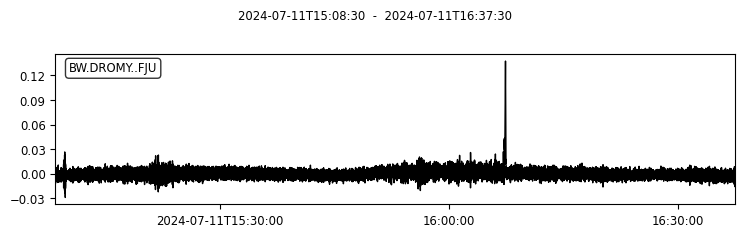

In [15]:
stx.plot();

## Load Demodulated Data

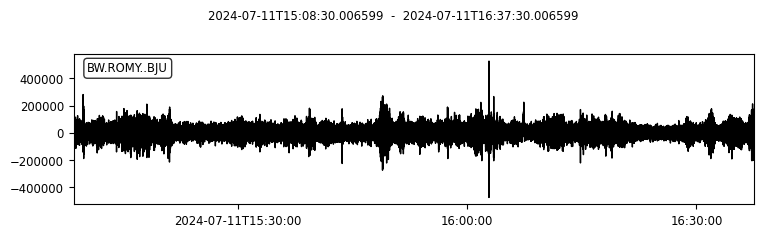

In [24]:
# stt =  read(root_path+f"/Downloads/mseed/30min/ROMY_BJU_{date}.mseed")
stt =  read(root_path+f"/Downloads/mseed/ROMY_BJU_{date}.mseed")
# stt =  read(root_path+f"/Downloads/mseed/ROMY_BJU_{date}.mseed", starttime=tbeg, endtime=tend)

stt = stt.detrend("linear")


t1 = stt[0].stats.starttime
t2 = stt[0].stats.endtime

stt = stt.trim(t1+cut_sec, t2-cut_sec)

stt.plot();

In [25]:
stt, stx

(1 Trace(s) in Stream:
BW.ROMY..BJU | 2024-07-11T15:08:30.006599Z - 2024-07-11T16:37:30.006599Z | 20.0 Hz, 106801 samples,
 1 Trace(s) in Stream:
BW.DROMY..FJU | 2024-07-11T15:08:30.000000Z - 2024-07-11T16:37:30.000000Z | 20.0 Hz, 106801 samples)

In [26]:
fmin, fmax = 0.001, 0.1

stt = stt.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)
stx = stx.filter("bandpass", freqmin=fmin, freqmax=fmax, corners=4, zerophase=True)


Nshift:  4 Tshift:  0.2 CC:  0.9968470415427019


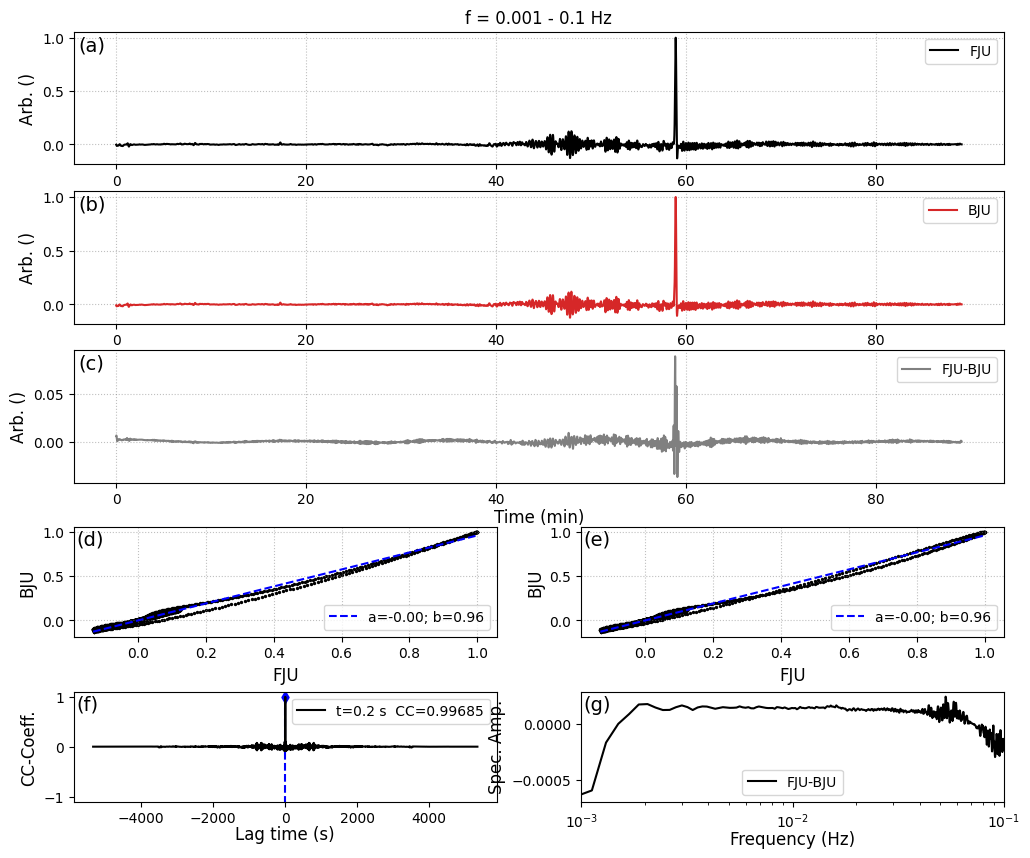

In [27]:
def __compare(st1, st2):

    from obspy.signal.cross_correlation import correlate, xcorr_max
    from numpy import nan_to_num, arange, array, linspace, imag, roll, nan
    from scipy.signal import hilbert
    from matplotlib.gridspec import GridSpec
    from submodules.compute_orthogonal_distance_regression import __compute_orthogonal_distance_regression
    from submodules.get_fft import __get_fft

    dt = st1[0].stats.delta

    tscale, tunit = 1/60, "min"

    times = st1[0].times()*tscale

    arr1 = st1.select(channel="FJU")[0].data
    arr2 = st2.select(channel="BJU")[0].data

    arr1 /= max(abs(arr1))
    arr2 /= max(abs(arr2))

    Nshift = len(arr1)

    ccf = correlate(arr1, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

    cclags = arange(-Nshift, Nshift+1) * dt

    shift, value = xcorr_max(ccf)

    arr2_shifted = roll(arr2, shift)

    print("Nshift: ", shift, "Tshift: ", shift*dt, "CC: ", value)


    b1, a1 = __compute_orthogonal_distance_regression(arr1, arr2, xerr=None, yerr=None, bx=None, by=None)

    b1_shifted, a1_shifted = __compute_orthogonal_distance_regression(arr1, arr2_shifted, xerr=None, yerr=None, bx=None, by=None)

    xxx = linspace(arr1.min(), arr1.max(), 100)


    res = arr1 - arr2_shifted

    res[:2*shift] *= nan
    res[-2*shift:] *= nan

    spec1, f1, p1 = __get_fft(arr1, dt, window='hann')
    spec2, f2, p2 = __get_fft(arr2_shifted, dt, window='hann')


    # ___________________________________________
    #

    Nrow, Ncol = 5, 2
    font = 12

    fig = plt.figure(figsize=(12, 10))

    gs0 = GridSpec(Nrow, Ncol, figure=fig, hspace=0.5)
    gs = GridSpec(Nrow, Ncol, figure=fig, hspace=0.2)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :])
    ax3 = fig.add_subplot(gs[2, :])
    ax4 = fig.add_subplot(gs0[3, :1])
    ax5 = fig.add_subplot(gs0[3, 1:])
    ax6 = fig.add_subplot(gs0[4, :1])
    ax7 = fig.add_subplot(gs0[4, 1:])

    plt.subplots_adjust(hspace=0.35)

    ax1.plot(times, arr1, color="black", label=f"{st1[0].stats.channel}")
    ax1.set_ylabel("Arb. ()", fontsize=font)
    # ax1.get_xaxis().set_visible(False)
    ax1.legend(loc=1)

    ax2.plot(times, arr2, color="tab:red", label=f"{st2[0].stats.channel}")
    ax2.legend(loc=1, ncol=1)
    ax2.set_ylabel("Arb. ()", fontsize=font)

    ax3.plot(times, res, color="grey", label=f"FJU-BJU")
    ax3.legend(loc=1, ncol=1)
    ax3.set_ylabel("Arb. ()", fontsize=font)
    ax3.set_xlabel(f"Time ({tunit})", fontsize=font, labelpad=1)

    ax4.scatter(arr1, arr2, color="black", s=2)
    ax4.plot(xxx, (a1+b1*xxx), ls="--", color="b", label=f"a={a1:.2f}; b={b1:.2f}")
    ax4.set_xlabel("FJU", fontsize=font)
    ax4.set_ylabel("BJU", fontsize=font)
    ax4.legend(loc=4)

    ax5.scatter(arr1, arr2_shifted, color="black", s=2)
    ax5.plot(xxx, (a1_shifted+b1_shifted*xxx), ls="--", color="b", label=f"a={a1_shifted:.2f}; b={b1_shifted:.2f}")
    ax5.set_xlabel("FJU", fontsize=font)
    ax5.set_ylabel("BJU", fontsize=font)
    ax5.legend(loc=4)

    ll = f"t={round(shift*dt, 1)} s  CC={round(value, 5)}"
    ax6.plot(cclags, ccf, color="k", label=ll)
    ax6.set_ylabel("CC-Coeff.", fontsize=font)
    ax6.set_xlabel("Lag time (s)", fontsize=font, labelpad=0)
    ax6.set_ylim(-1.1, 1.1)
    ax6.axvline(shift*dt, -1, 1, color="b", ls="--", zorder=0)
    ax6.scatter(shift*dt, value, color="b", marker="d", zorder=0)
    ax6.legend()
    # ax6.text(.005, .97, ll, ha='left', va='top', transform=ax6.transAxes, fontsize=font)

    ax7.plot(f1, (spec1-spec2), color="k", label=f"FJU-BJU")
    # ax7.plot(f2, spec2, color="tab:red", label=f"BJU")
    ax7.set_ylabel("Spec. Amp.", fontsize=font)
    ax7.set_xlabel("Frequency (Hz)", fontsize=font, labelpad=0)
    ax7.set_xscale("log")
    ax7.set_xlim(fmin, fmax)
    ax7.legend(ncol=2, loc=8)

    for _k, (ax, ll) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6, ax7], ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)'])):
        ax.text(.005, .97, ll, ha='left', va='top', transform=ax.transAxes, fontsize=font+2)


    ax1.set_title(f"f = {fmin} - {fmax} Hz")

    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.grid(ls=":", alpha=0.5, zorder=0, color="grey")

    plt.show();
    return fig

fig = __compare(stx, stt)

fig.savefig(path_to_figs+f"SP_{date}_{fmin}_{fmax}_comparison.png", format="png", dpi=150, bbox_inches='tight')


In [ ]:
from obspy.signal.cross_correlation import correlate, xcorr_max
from numpy import roll

# prepare arrays
arr1 = stx.select(channel="FJU")[0].data
arr2 = stt.select(channel="BJU")[0].data


# number of samples
Nshift = len(arr1)

# extract sampling rate in seconds
dt = stt[0].stats.delta

# compute cross-correlation function
ccf = correlate(arr1, arr2, shift=Nshift, demean=False, normalize='naive', method='fft')

# compute lag time
cclags = np.arange(-Nshift, Nshift+1) * dt

# extract maximum CC and lag time
shift, ccmax = xcorr_max(ccf)

print(shift, ccmax)

plt.plot(cclags, ccf)

s = shift*2

arr2 = roll(arr2, shift)


In [ ]:
t1 = stt[0].times()[s:-s]
t2 = stx[0].times()[s:-s]

dat1 = arr1[s:-s]/max(abs(arr1[s:-s]))
dat2 = arr2[s:-s]/max(abs(arr2[s:-s]))

residual = dat1 - dat2

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(15, 5))

ax[0].plot(t1, dat1, color="tab:blue")
ax[1].plot(t2, dat2, color="tab:orange")
ax[2].plot(t1, residual, color="grey")


In [11]:
def __sine_fit(data, times, df, Tinterval=20, Toverlap=2, plot=True):

    '''
    Fitting a sin-function to the data to estimate an instantaneous frequency
    '''

    import matplotlib.pyplot as plt

    from scipy import optimize
    from numpy import sin, hanning, pi, arange, array, diag, zeros, nan, isnan


    def func(x, a, f):
        return a * sin(2 * pi * f * x)

    def func(x, a, f, p):
        return a * sin(2 * pi * f * x +  p)

    # to array
    data = array(data)

    # npts per interval
    Nsamples = int(Tinterval*df)
    Noverlap = int(Toverlap*df)

    # npts in data
    Ndata = data.size

    # create time reference
    tt = times

    # amount of windows
    Nwin = 0
    x2 = Nsamples
    while x2 < Ndata:
        int(Ndata / (Nsamples - Noverlap))
        x2 = x2 + Nsamples - Noverlap
        Nwin += 1

    print(Nwin, Ndata, Nsamples, Noverlap)

    # prepare lists
    amps = zeros(Nwin)*nan
    freq = zeros(Nwin)*nan
    phas = zeros(Nwin)*nan
    time = zeros(Nwin)*nan
    cfs = zeros(Nwin)*nan
    cas = zeros(Nwin)*nan

    # initial values
    a00 = 0.9
    f00 = 302.5
    p00 = 0

    # specify start indices
    n1, n2 = 0, Nsamples

    # looping
    for _win in range(Nwin):

        # npts = Nsamples-Noverlap

        # set start values at begin
        if _win == 0:
            a0, f0, p0 = a00, f00, p00

        # reste start values if nan
        if isnan(a0) or isnan(f0) or isnan(p0):
            a0, f0, p0 = a00, f00, p00

        _time = tt[n1:n2]
        _data = data[n1:n2]

        # xx = 0
        # cf, ca = 1, 1

        # condition for fit
        # while cf > 0.001 and ca > 0.001:
        try:
            params, params_covariance = optimize.curve_fit(func,
                                                           _time,
                                                           _data,
                                                           p0=[a0, f0, p0],
                                                           check_finite=True,
                                                          )
            f0 = params[1]
            a0 = params[0]
            p0 = params[2]

            ca, cf = diag(params_covariance)[0], diag(params_covariance)[1]

        except:
            # print(f" -> fit failed {_win}")
            f0, a0, p0, ca, cf = nan, nan, nan, nan, nan

            # # counter to avoid infinitiy loop
            # if xx > 500:
            #     break
            # else:
            #     xx += 1

        if cf > 0.001 or ca > 0.001:
            f0, a0, p0 = nan, nan, nan

        # append values
        amps[_win] = a0
        freq[_win] = f0
        phas[_win] = p0
        time[_win] = (tt[n2]-tt[n1])/2 + tt[n1]

        cfs[_win] = cf
        cas[_win] = ca

        if plot:
            if _win == Nwin - 1:
                fig, ax = plt.subplots(1, 1, figsize=(15, 5))

                ax.plot(_time, _data, color='black')

                ax.plot(_time, func(_time, params[0], params[1], params[2]), color='red')

                plt.show();

        # update index
        n1 = n1 + Nsamples - Noverlap
        n2 = n2 + Nsamples - Noverlap


    # timeline
    # step = (Tinterval-Toverlap)
    # time = arange(step/2, Ndata/df, step)

    if plot:

        Nrow, Ncol = 3, 1

        font = 12

        fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

        plt.subplots_adjust(hspace=0.1)

        ax[0].errorbar(time, freq, cfs)
        ax[1].errorbar(time, amps, cas)
        ax[2].plot(time, phas)

        plt.show();

    return time, freq, amps, phas

In [ ]:
X1, X2 = 0, 4_000_000
test = st[0].data[X1:X2]
time = st[0].times()[X1:X2]

test = st[0].data
time = st[0].times()


df = st[0].stats.sampling_rate

tt, freq, amp, pha = __sine_fit(test, time, df, Tinterval=1, Toverlap=0.9, plot=True)
tt, freq

53991 27000001 5000 4500


In [ ]:
plt.plot(time, test)

In [ ]:
def __makeplot():

    import matplotlib.pyplot as plt

    Nrow, Ncol = 3, 1

    font = 12

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 5), sharex=True)

    plt.subplots_adjust(hspace=0.1)

    ax[0].plot(tt, freq)
    ax[1].plot(tt, amp)
    ax[2].plot(tt, pha)

    # ax.set_xscale("log")

    # ax.set_ylim(0, 8000)

    # ax.grid(which="both", ls="--", color="grey", alpha=0.5, zorder=0)

    plt.show();
    # return fig

fig = __makeplot();